In [1]:
import warnings
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from scipy.stats import norm
import torch
from torch.utils.data import DataLoader
import pickle
import os


from varpi.wasserstein_min import get_best_lstm_pdf_params
from utils.dist_utils import generate_smooth_pdf
from utils.optuna_utils import load_qlstm_model
from utils.data_utils import get_test_dataset

warnings.filterwarnings("ignore")

with open("config.json", "r") as f:
    CONFIG = json.load(f)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

taus = CONFIG["general"]["quantiles"]

test_start_date = CONFIG["general"]["dates"]["test_period"]["start_date"]
test_end_date = CONFIG["general"]["dates"]["test_period"]["end_date"]

val_start_date = CONFIG["general"]["dates"]["validation_period"]["start_date"]
val_end_date = CONFIG["general"]["dates"]["validation_period"]["end_date"]

seed = CONFIG["general"]["seed"]
np.random.seed(seed)
torch.manual_seed(seed)


/home/chaddicus/miniconda3/envs/opt-price/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the Model

In [4]:
qlstm_model, qlstm_params = load_qlstm_model()
qlstm_model.load_state_dict(torch.load('models/qlstm_model.pth'))
qlstm_model = qlstm_model.to(DEVICE)

In [5]:
normalization_window = qlstm_params['normalazation_window']
val_dataset = get_test_dataset(normalization_lookback=normalization_window,
                                start_date=test_start_date,
                                end_date=test_end_date,
                                test=True)

# Infrence the Model to get all S&P500 tickers

In [6]:
def get_all_quantiles(data_set, model):
    all_estimated_quantiles = {}
    group_names = [
        "cryptocurrencies",
        "currency pairs",
        "commodities",
        "euro stoxx 50",
        "s&p 500",
        "nikkei 225"
    ]
    for group_name in tqdm(group_names, desc='Inferencing models'):
        group_assets = [a["asset"] for a in data_set.datas[group_name]]
        sub_values = {
            "observed_returns": [],
            "future_returns": [],
            "all_pred_quantiles": [],
        }
        for asset in group_assets:
            data_set.set_main_asset(asset)
            data_loader = DataLoader(data_set, batch_size=1024, shuffle=False)
            model.eval()
            for x, s, z, y, obs in data_loader:
                x, s, z, y = x.to(DEVICE), s.to(DEVICE), z.to(DEVICE), y.to(DEVICE)
                s = s.mean(dim=1)

                with torch.no_grad():
                    _, estimated_quantiles = model(x, s, z)
                sub_values["all_pred_quantiles"].append(estimated_quantiles.detach().cpu().numpy())
                sub_values["observed_returns"].append(obs.cpu().numpy().squeeze())
                sub_values["future_returns"].append(y.cpu().numpy().squeeze())
        if len(sub_values["observed_returns"]) == 0:
            continue
        sub_values["observed_returns"] = np.concatenate(sub_values["observed_returns"], axis=0)
        sub_values["future_returns"] = np.concatenate(sub_values["future_returns"], axis=0)/100
        sub_values["all_pred_quantiles"] = np.concatenate(sub_values["all_pred_quantiles"], axis=0)/100
        
        all_estimated_quantiles[group_name] = sub_values
    return all_estimated_quantiles

In [ ]:
T = 30
for T in range(15, 31):
    folder_name = "stored_quants"
    normalization_window = qlstm_params['normalazation_window']
    val_dataset = get_test_dataset(normalization_lookback=normalization_window,
                                    start_date=val_start_date,
                                    end_date=val_end_date,
                                    lookforward=T,
                                    test=True)
    test_quantiles = get_all_quantiles(val_dataset, qlstm_model)
    save_path = os.path.join(folder_name, f"quantiles_{T}.pkl")
    with open(save_path, 'wb') as f:
        pickle.dump(test_quantiles, f)

In [7]:
val_dataset = get_test_dataset(normalization_lookback=normalization_window,
                                    start_date=val_start_date,
                                    end_date=val_end_date,
                                    lookforward=30,
                                    test=True)
test_quantiles = get_all_quantiles(val_dataset, qlstm_model)

Inferencing models: 100%|██████████| 6/6 [00:25<00:00,  4.32s/it]


Pick a random index to look at the distribution

In [9]:
idx = np.random.randint(0, len(test_quantiles["s&p 500"]["observed_returns"]))
obs_rets = test_quantiles["s&p 500"]["observed_returns"][idx]
future_rets = test_quantiles["s&p 500"]["future_returns"][idx]
quants = test_quantiles["s&p 500"]["all_pred_quantiles"][idx]
idx

4059

In [10]:
pdf_params = get_best_lstm_pdf_params(_)

[I 2025-01-21 18:24:40,948] Using an existing study with name 'wasserstein_distance_qlstm' instead of creating a new one.


In [11]:
grid, pdf, cdf = generate_smooth_pdf(quants, np.array(taus), **pdf_params)

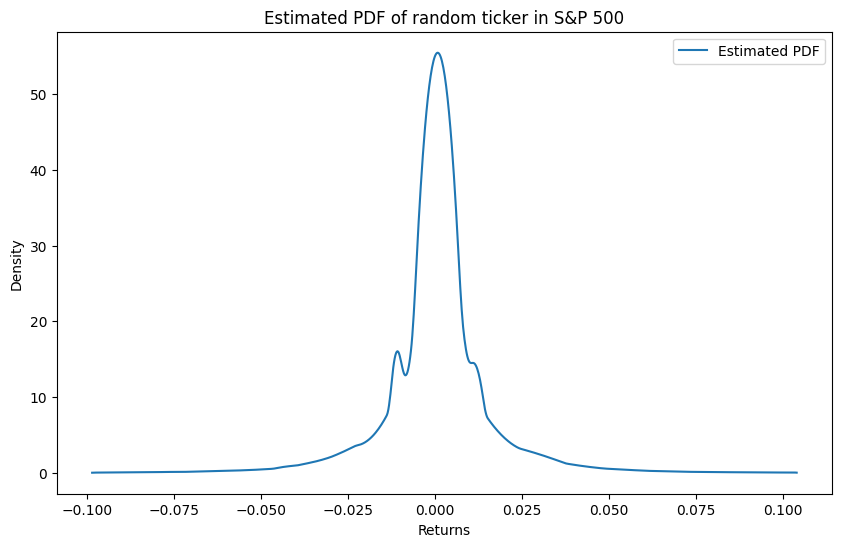

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(grid, pdf, label="Estimated PDF")
plt.ylabel("Density")
plt.xlabel("Returns")
plt.title("Estimated PDF of random ticker in S&P 500")
plt.legend()
plt.show()

In [15]:
def generate_random_walk(cdf, T):
    random_uniform_samples = np.random.uniform(0, 1, T)
    predicted_samples = np.interp(random_uniform_samples, cdf, grid)
    predicted_samples = np.concatenate([[0], predicted_samples])
    discrete_random_walk = np.cumsum(predicted_samples)
    return discrete_random_walk


In [17]:
n_samples = 10000
random_walks = []
for i in range(n_samples):
    random_walks.append(generate_random_walk(cdf, 30))
random_walks = np.array(random_walks)

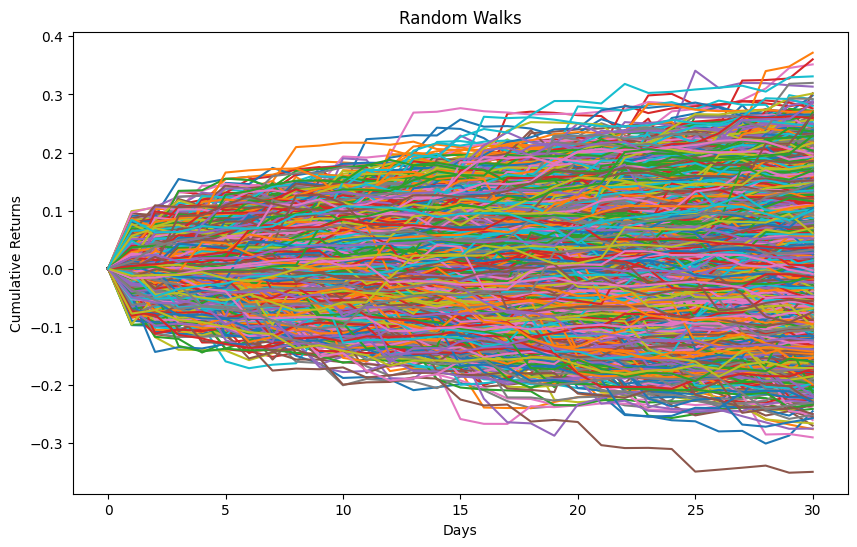

In [18]:
plt.figure(figsize=(10, 6))
for walk in random_walks:
    plt.plot(walk)
plt.ylabel("Cumulative Returns")
plt.xlabel("Days")
plt.title("Random Walks")
plt.show()

In [21]:
pdf_mean = np.trapz(grid * pdf, grid)
pdf_std = np.sqrt(np.trapz((grid - pdf_mean) ** 2 * pdf, grid))

In [26]:
theoretical_mean = []
theoretical_std = []

empircal_mean = []
empirical_std = []
for i in range(30):
    theoretical_mean.append(pdf_mean * i)
    theoretical_std.append(pdf_std * np.sqrt(i))
    
    empircal_mean.append(np.mean(random_walks[:, i]))
    empirical_std.append(np.std(random_walks[:, i]))

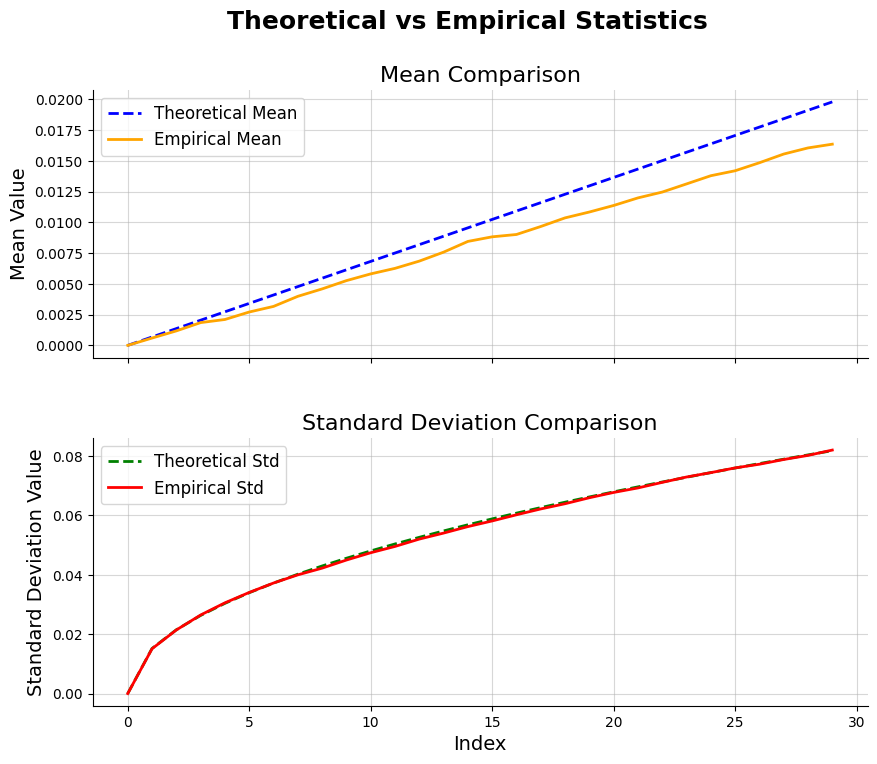

In [33]:
x = np.arange(30)

# Create the plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'hspace': 0.3})

# First plot: Means
axes[0].plot(x, theoretical_mean, label="Theoretical Mean", linestyle="--", color="blue", linewidth=2)
axes[0].plot(x, empircal_mean, label="Empirical Mean", linestyle="-", color="orange", linewidth=2)
axes[0].set_title("Mean Comparison", fontsize=16)
axes[0].set_ylabel("Mean Value", fontsize=14)
axes[0].grid(alpha=0.5)
axes[0].legend(fontsize=12)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Second plot: Standard Deviations
axes[1].plot(x, theoretical_std, label="Theoretical Std", linestyle="--", color="green", linewidth=2)
axes[1].plot(x, empirical_std, label="Empirical Std", linestyle="-", color="red", linewidth=2)
axes[1].set_title("Standard Deviation Comparison", fontsize=16)
axes[1].set_xlabel("Index", fontsize=14)
axes[1].set_ylabel("Standard Deviation Value", fontsize=14)
axes[1].grid(alpha=0.5)
axes[1].legend(fontsize=12)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Add a unified title
fig.suptitle("Theoretical vs Empirical Statistics", fontsize=18, fontweight='bold')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

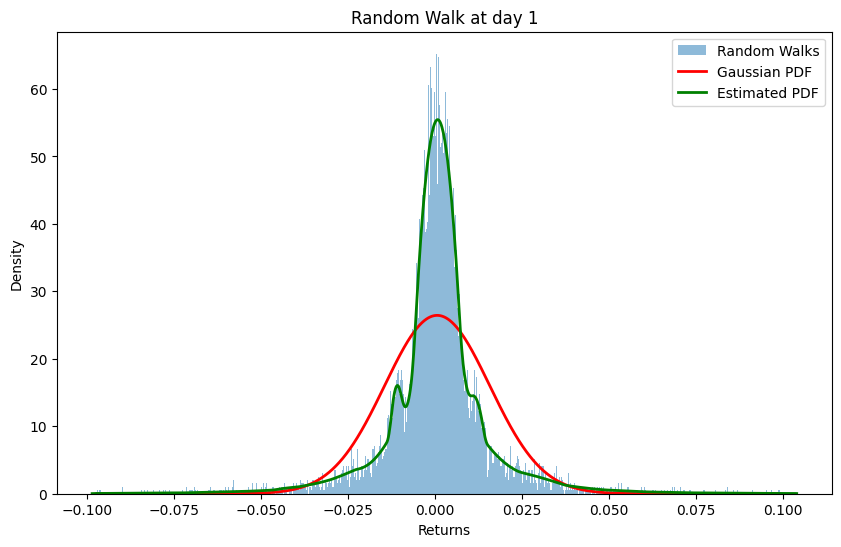

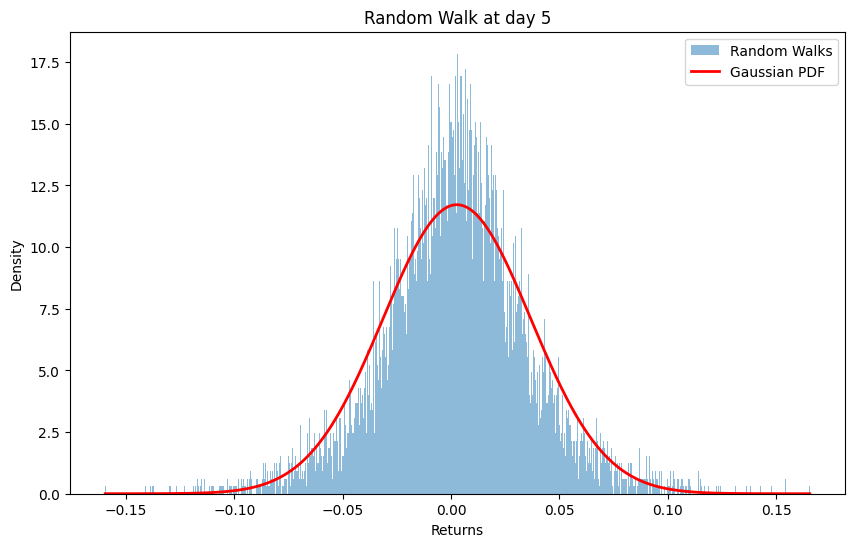

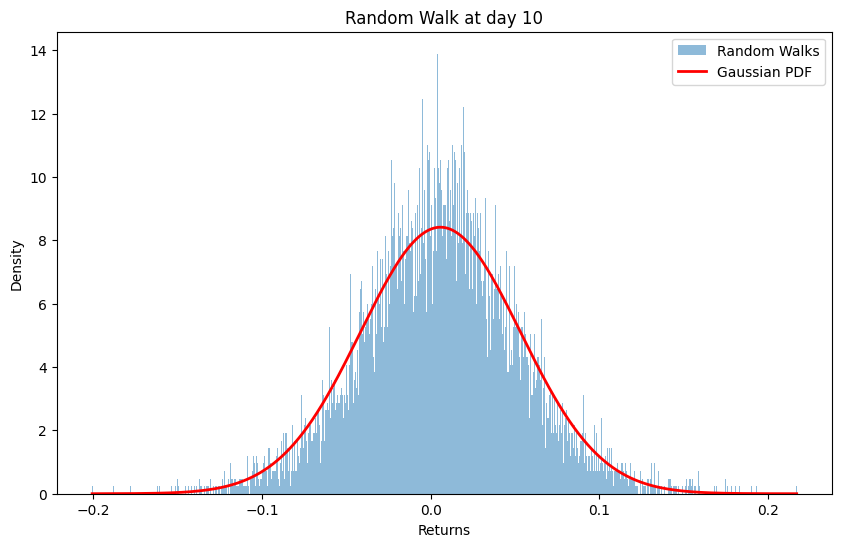

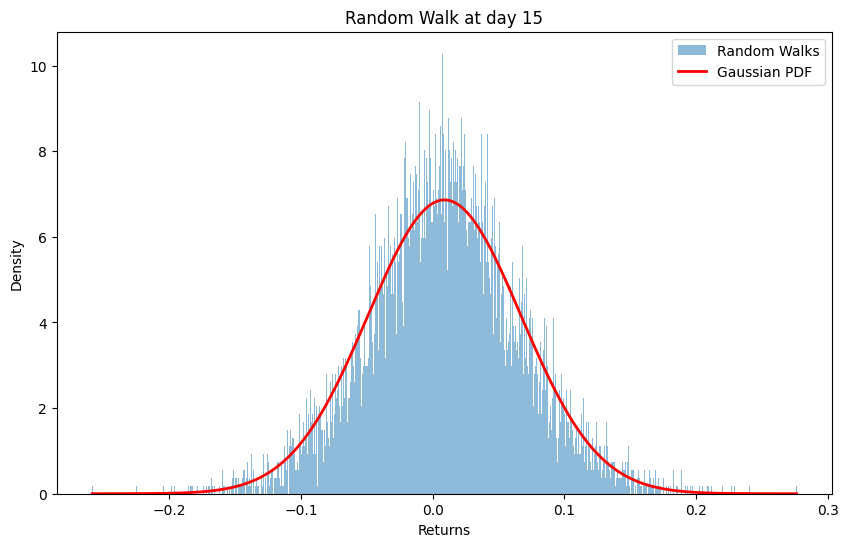

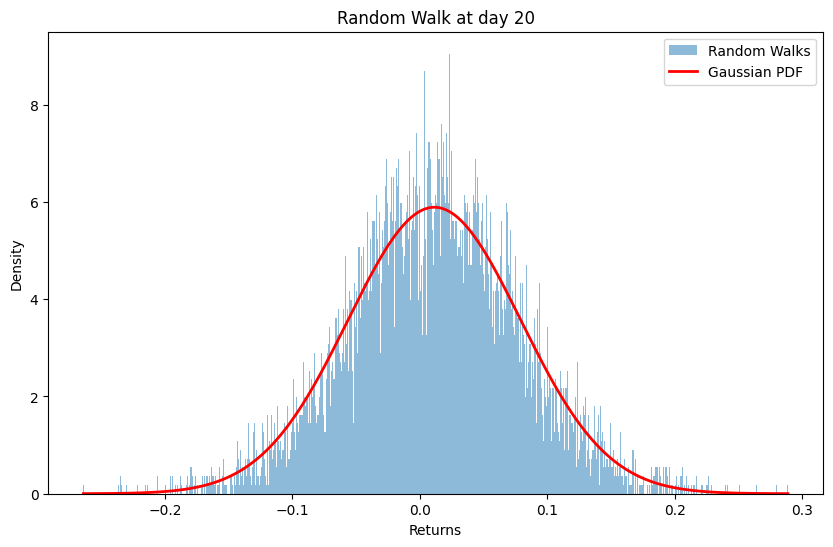

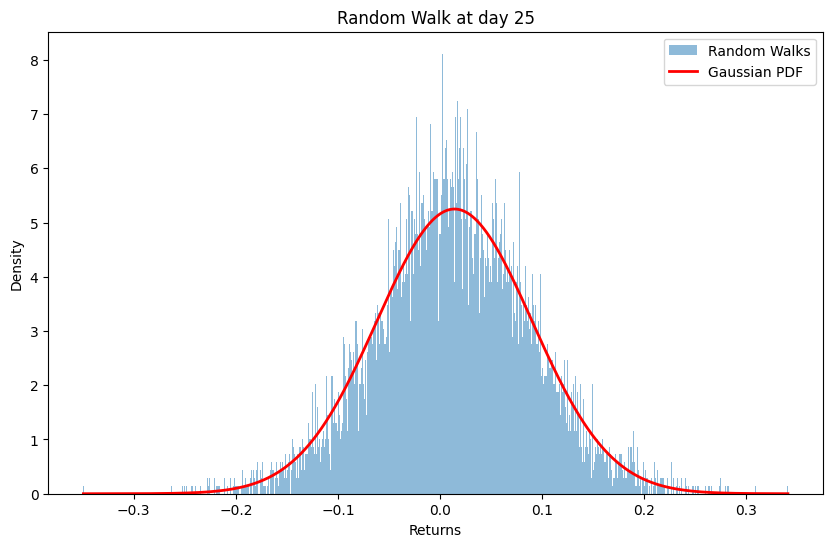

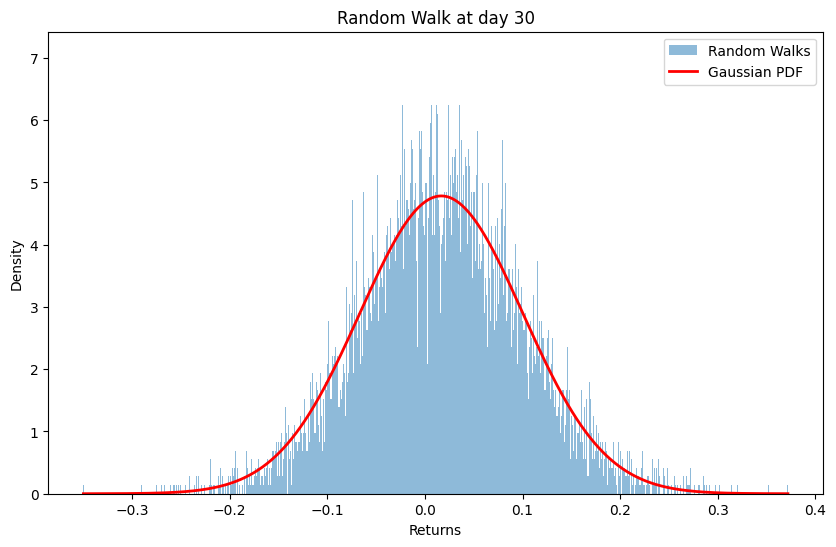

In [46]:
for i in range(31):
    if (i != 1 and i % 5 != 0 and i != 30) or i == 0:
        continue
    plt.figure(figsize=(10, 6))
    plt.hist(random_walks[:, i], bins=1000, density=True, alpha=0.5, label="Random Walks")
    emp_mean = np.mean(random_walks[:, i])
    emp_std = np.std(random_walks[:, i])

    min_val = np.min(random_walks[:, i])
    max_val = np.max(random_walks[:, i])
    
    gaussian_grid = np.linspace(min_val, max_val, 10000)
    gaussian_pdf = norm.pdf(gaussian_grid, loc=emp_mean, scale=emp_std)
    
    plt.plot(gaussian_grid, gaussian_pdf, label="Gaussian PDF", color="red", linewidth=2)
    
    if i == 1:
        plt.plot(grid, pdf, label="Estimated PDF", color="green", linewidth=2)
    plt.ylabel("Density")
    plt.xlabel("Returns")
    plt.title(f"Random Walk at day {i}")
    plt.legend()
    plt.show()
     